## Setup

In [ ]:
dir = dirname(pwd()) * "/PROJECT"
include(dir * "/functions/Preamble.jl")
@everywhere dir = dirname(pwd()) * "/PROJECT"

t0 = now()

In [5]:
# Hamiltonian constants
@everywhere global const λ::Float = 1
@everywhere global const 𝒥::Float = 0

# which dynamics to use (only affects microcanonical functions)
@everywhere global const twoFlip::Bool = true

# demon quantisation
@assert 𝒥==0 || λ==0 # otherwise demons will break b/c not quantised
@everywhere global const δE::Int = (λ==0) ? 8*𝒥 : 4*λ

Lx  Ly  nT    t     t_th
50  50  50  50000  10000
25  25  25  10000   2500

## Data Structure


In [8]:
@everywhere include(dir * "/functions/DataStructure.jl")
@everywhere include(dir * "/functions/Plotting.jl")
@everywhere include(dir * "/functions/Statistics.jl")
@everywhere include(dir * "/functions/Simulation.jl")

## Thermal Conductivity

### Microcanonical Dynamics

In [53]:
@everywhere include(dir * "/functions/simulationFunctions/MicroKubo.jl")

In [60]:
# PARAMETERS
L = [10, 10]
PBC = [true, true]
Basis = CubicBasis(length(L))

Tmin = 0.01
Tmax = 10.0
NumT = 50

T = range(Tmin, Tmax, length=NumT)

𝒽 = range(0, 1, length=7)

num_histories = 10
therm_runtime = 10000
runtime = 10000
t_therm = 5000
t_autocorr = 100
N_blocks = -1
t_cutoff = 100


# EVALUATION
κ, C, Diff, M, ℙ, κStd, CStd, DiffStd, MStd, ℙStd = MKuboSimulation(L, PBC, Basis, num_histories, runtime, therm_runtime, t_therm, t_autocorr, N_blocks, t_cutoff, T, 𝒽);

In [ ]:
#for t in testing
#    scatter(t[1], t[3], color=:black) # t[2]=h=0 for now
#end

In [ ]:
now()

In [1]:
colors = jetmap(size(κ, 2));

LoadError: UndefVarError: κ not defined

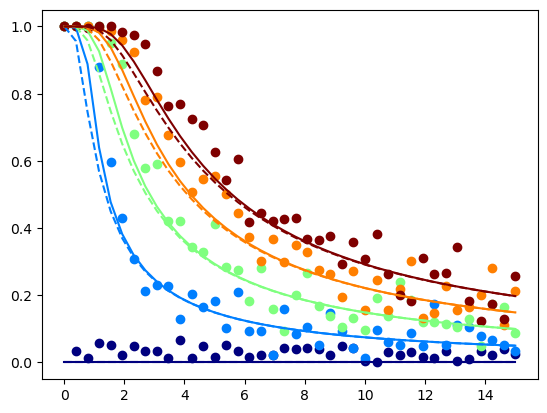

In [64]:
figure()
Tfun = (M, h) -> (h .+ 0.5 .* M .^ 3) ./ atanh.(M)
function Mfun(T, h)
    m = zeros(length(T))
    
    if h==0
        return m
    end
    
    for i in eachindex(T)
        m[i] = find_zero((M) -> Tfun(M, h) - T[i], (0, 1))
    end
    return m
end

Mfun0 = (T, h) -> tanh.(h ./ T)

for n in 1:size(κ, 2)
    #plot(T, Mfun0(T, 𝒽[n]), color=colors[n], "--")
    #plot(T, Mfun(T, 𝒽[n]), color=colors[n])
    scatter(T, M[:,n], color=colors[n])
end
savefig("figs/Micro_Kubo_Magnetisation.png")

In [ ]:
figure()
#ℙfunMF = (T, h) -> (1 .- Mfun0(T, h) .^2) ./ 3
ℙfunLim = (T, h) -> (1 .- Mfun0(T, h) .^2) ./ 4

for n in 1:size(κ, 2)
    #plot(T, ℙfunMF(T, 𝒽[n]), color=colors[n], "--")
    #plot(T, ℙfunLim(T, 𝒽[n]), color=colors[n])
    scatter(T, ℙ[:,n], color=colors[n])
end
savefig("figs/Micro_Kubo_Percolation.png")

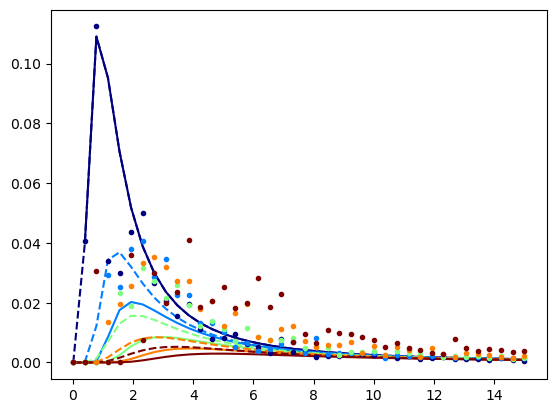

In [82]:
figure()
nfun0 = (T) -> 0.5 .* (1 .- tanh.(1 ./ T))
nfun = (T, h) -> 1 ./ (1 .+ exp.(2 ./ T) .* exp.(h ./ T ./ sqrt.(nfun0(T))))
Kfun = (T, h) -> (2 .* nfun(T, h) ./ T.^2) .* (1 .- nfun(T, h)) .* (1 .- Mfun(T, h)) ./ 2 # additional magnetisation factor for +-+- bond percolation
Kfun0 = (T, h) -> (2 .* nfun0(T) ./ T.^2) .* (1 .- nfun0(T)) .* (1 .- Mfun(T, h)) ./ 2

for n in 1:size(κ, 2)
    #plot(T, Kfun(T, 𝒽[n]), color=colors[n], "--")
    #plot(T, Kfun0(T, 𝒽[n]), color=colors[n])
    #plotWithError(κ[:,n], T, colors[n], κStd[:,n])
    plot(T, κ[:,n], color=colors[n])
end
ylim([0, 0.3])
savefig("figs/Micro_Kubo_Conductivity.png")

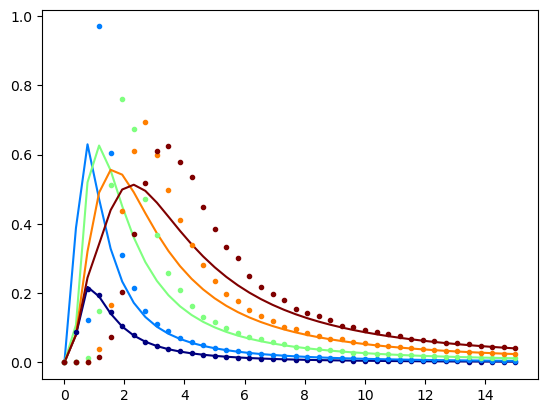

In [76]:
figure()
Cfun = (T, h) -> (sech.(1 ./T).^2 + 2 * h^2 .* sech.(h ./T).^2) ./ 2 ./ T.^2
for n in 1:size(κ, 2)
    #plot(T, Cfun(T, 𝒽[n]), color=colors[n])
    #plotWithError(C[:,n], T, colors[n], CStd[:,n])
    plot(T, C[:,n], color=colors[n])
end
ylim([0, 0.3])
savefig("figs/Micro_Kubo_Capacity.png")

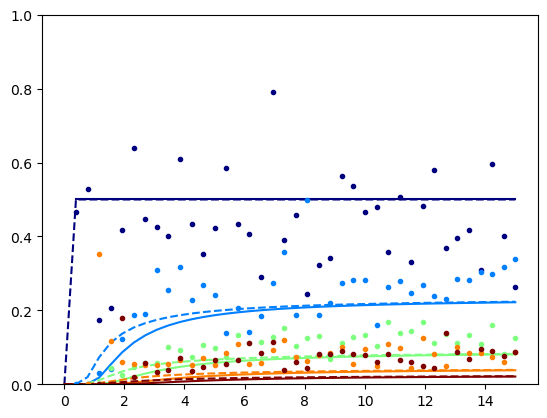

(0.0, 1.0)

In [83]:
figure()
Dfun = (T, h) -> Kfun(T, h) ./ Cfun(T, h)
Dfun0  = (T, h) -> Kfun0(T, h) ./ Cfun(T, h)
for n in 1:size(κ, 2)
    #plot(T, Dfun(T, 𝒽[n]), color=colors[n], "--")
    #plot(T, Dfun0(T, 𝒽[n]), color=colors[n])
    #plotWithError(Diff[:,n], T, colors[n], DiffStd[:,n])
    plot(T, Diff[:,n], color=colors[n])
end
savefig("figs/Micro_Kubo_Diff.png")
ylim([0, 2.0])

In [ ]:
κ = Nothing
C_σ = Nothing
κStd = Nothing 
C_σStd = Nothing